In [ ]:
!pip install imbalanced-learn

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


# SMOTE for oversampling
from imblearn.over_sampling import SMOTE

# 3. Baca dataset
csv_path = '/content/drive/MyDrive/Tugas ML/diabetes.csv'
df = pd.read_csv(csv_path)

# 4. Ambil hanya 4 fitur penting
selected_features = ['Glucose', 'BMI', 'Age', 'Insulin', 'Outcome']
df = df[selected_features]

# 5. Nilai 0 jadi NaN untuk fitur tertentu
for col in ['Glucose', 'BMI', 'Insulin']:
    df[col] = df[col].replace(0, np.nan)

# 6. Imputasi nilai NaN dengan median
imputer = SimpleImputer(strategy='median')
df[['Glucose', 'BMI', 'Insulin']] = imputer.fit_transform(df[['Glucose', 'BMI', 'Insulin']])

# 7. Pisahkan fitur dan label
X = df.drop('Outcome', axis=1)
y = df['Outcome']

Mounted at /content/drive


In [ ]:
# 8. Split data train/test (sebelum normalisasi dan oversampling agar tidak ada data leak)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 9. Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

# 10. Oversampling dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_train)

In [ ]:
# 11. Latih model KNN dengan tuning
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Inisialisasi model
knn = KNeighborsClassifier()

# Grid Search
grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

# Fit ke data
grid_knn.fit(X_scaled, y_train)

# Hasil terbaik
print("Best KNN Params:", grid_knn.best_params_)

# Simpan model terbaik
model_knn = grid_knn.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best KNN Params: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}


In [ ]:
# 12. Evaluasi model
y_pred = model_knn.predict(X_scaled_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["Negatif", "Positif"]))
print("Akurasi:", accuracy_score(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

     Negatif       0.80      0.85      0.82       150
     Positif       0.69      0.59      0.64        81

    accuracy                           0.76       231
   macro avg       0.74      0.72      0.73       231
weighted avg       0.76      0.76      0.76       231

Akurasi: 0.7619047619047619


In [ ]:
# Cek overfit
y_train_pred = model_knn.predict(X_scaled)

print("\n=== Classification Report ===")
print(classification_report(y_train, y_train_pred, target_names=["Negatif", "Positif"]))
print("Akurasi:", accuracy_score(y_train, y_train_pred))


=== Classification Report ===
              precision    recall  f1-score   support

     Negatif       0.82      0.87      0.85       350
     Positif       0.73      0.64      0.68       187

    accuracy                           0.79       537
   macro avg       0.78      0.76      0.77       537
weighted avg       0.79      0.79      0.79       537

Akurasi: 0.7932960893854749


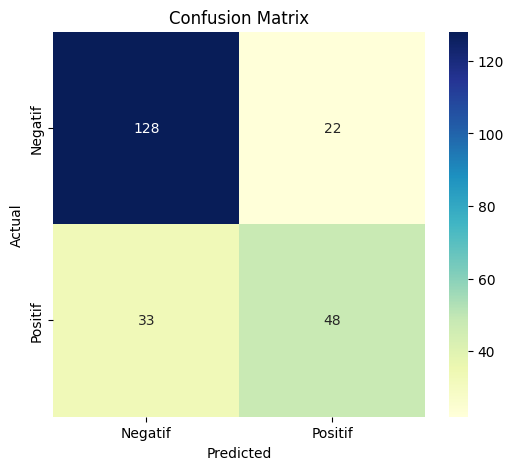

In [ ]:
# 12. Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            cmap='YlGnBu', xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()